In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import time
import numpy as np

/Users/prishashah/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person = 70, resize = 0.4)

In [3]:
lfw_people.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [4]:
lfw_people.images.shape

(1288, 50, 37)

In [5]:
lfw_people.data.shape

(1288, 1850)

In [6]:
sample,height,width=lfw_people.images.shape

In [7]:
print("height of the image:",height)
print("width of the image:",width)

height of the image: 50
width of the image: 37


In [8]:
X=lfw_people.data
Y=lfw_people.target

In [9]:
print(Y)
print(lfw_people.target_names)

[5 6 3 ... 5 3 5]
['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


In [10]:
print(X.shape)
print(Y.shape)

(1288, 1850)
(1288,)


In [11]:
features=X.shape[1]

In [12]:
target_names=lfw_people.target_names
classes = target_names.shape[0]

In [13]:
print("Number of data samples:",sample,'\n')
print("Number of features in the data:",features,'\n')
print("Number of class labels",classes)

Number of data samples: 1288 

Number of features in the data: 1850 

Number of class labels 7


In [14]:
def plot_gallery(image, titles, h, w, row = 3, col = 4):
    plt.figure(figsize =(2 * col, 2* row))
    plt.subplots_adjust(left =0.1, right  =1,hspace=0.3,wspace=0.3)
    for i in range(row * col):
        plt.subplot(row, col, i + 1)
        plt.imshow(image[i].reshape((h, w)), cmap = plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())

In [15]:
def true_title(Y, target_names, i):
    true_name = target_names[Y[i]].rsplit(' ', 1)[-1]
    #print(true_name)
    return 'true label: % s' % (true_name)
#true_title(Y, target_names, 0)

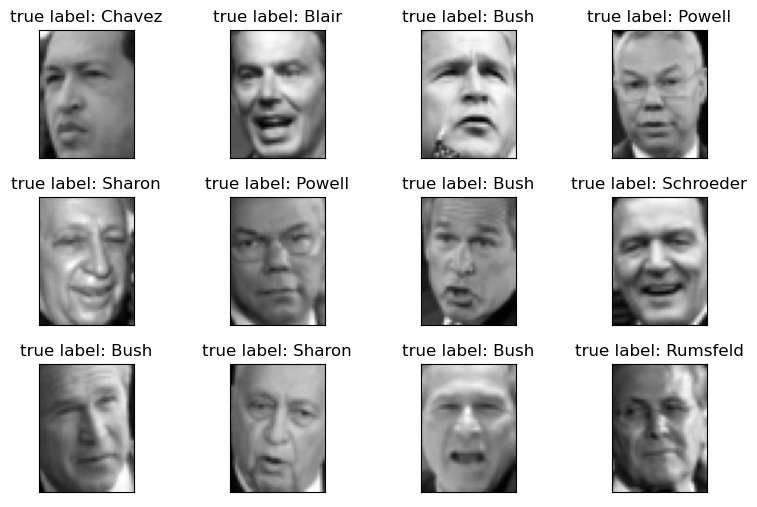

In [16]:
true_titles = [true_title(Y, target_names, i) for i in range(Y.shape[0])]
plot_gallery(X, true_titles, height, width)

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 42)
print("Size of Training Data is %d" %(Y_train.shape[0]))
print("Size of Testing Data is %d" %(Y_test.shape[0]))

Size of Training Data is 966
Size of Testing Data is 322


In [18]:
pca=PCA()

In [19]:
X_train_pca=pca.fit_transform(X_train)
X_test_pca=pca.fit_transform(X_test)

In [20]:
k=0
total=sum(pca.explained_variance_)
current_sum=0
while current_sum/total<0.99:
    current_sum+=pca.explained_variance_[k]
    k=k+1
print(k)

199


In [21]:
n_components = k

In [22]:
pca=PCA(n_components=k)

In [23]:
X_train_pca=pca.fit_transform(X_train)
X_test_pca=pca.fit_transform(X_test)

In [24]:
print(pca.components_)

[[-0.0058552  -0.00584169 -0.00485428 ... -0.01520044 -0.0104281
  -0.00327744]
 [-0.01792374 -0.01773616 -0.02102287 ...  0.03921691  0.03599073
   0.03327798]
 [-0.02058659 -0.01660852 -0.01446026 ... -0.03291177 -0.02863887
  -0.02148772]
 ...
 [-0.07067183 -0.01828166  0.02534812 ... -0.05458202 -0.02190718
  -0.04365925]
 [-0.0204783   0.01117963  0.07619911 ... -0.03198007  0.03813364
  -0.00142388]
 [ 0.01367826  0.00471437 -0.00557743 ...  0.00629641  0.03808524
  -0.05238417]]


In [25]:
eigenfaces = pca.components_.reshape((n_components, height, width))
print("shape of the eigenfaces:",eigenfaces.shape)

shape of the eigenfaces: (199, 50, 37)


Projecting the eigenfaces


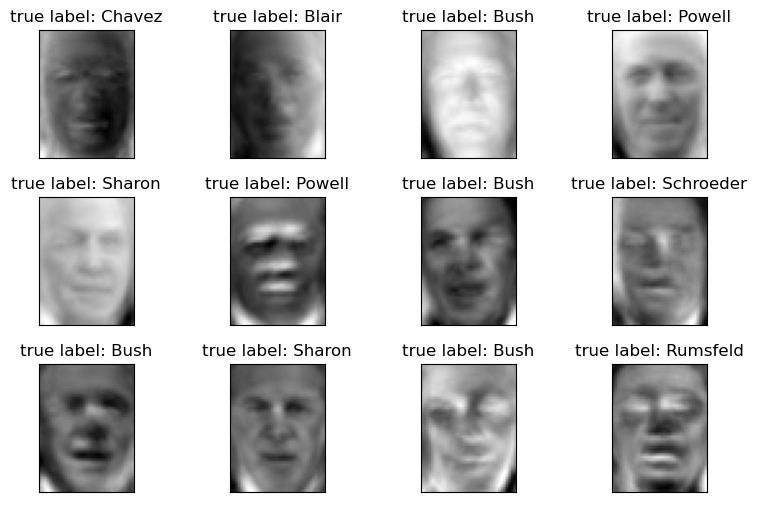

In [26]:
print("Projecting the eigenfaces")
true_titles = [true_title(Y, target_names, i) for i in range(Y.shape[0])]
plot_gallery(eigenfaces, true_titles, height, width)

In [27]:
pca = PCA(n_components=n_components, whiten=True)
transform_start_time = time.time()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
transform_time = time.time() - transform_start_time
print("Training completed in {:.3f}".format(transform_time))

Training completed in 0.225


In [28]:
print("Fitting the classifier to the training set")
t0 = time.time()
param_grid = {'C': [1, 5, 10],'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
clf = GridSearchCV(SVC(kernel="rbf", class_weight="balanced"), param_grid)
clf = clf.fit(X_train_pca, Y_train)
print("Completed in %0.3fs" % (time.time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)
 
print("Predicting people's names on the test set")
start_time = time.time()
Y_pred = clf.predict(X_test_pca)
print("Completed in % 0.3fs" % (time.time() - start_time))

print(classification_report(Y_test, Y_pred, target_names = target_names))

print("Confusion Matrix is:")
print(confusion_matrix(Y_test, Y_pred, labels = range(classes)))
cm=confusion_matrix(Y_test, Y_pred, labels = range(classes))


Fitting the classifier to the training set
Completed in 20.787s
Best estimator found by grid search:
SVC(C=5, class_weight='balanced', gamma=0.0005)
Predicting people's names on the test set
Completed in  0.072s
                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.62      0.55        13
     Colin Powell       0.76      0.87      0.81        60
  Donald Rumsfeld       0.74      0.74      0.74        27
    George W Bush       0.96      0.88      0.92       146
Gerhard Schroeder       0.77      0.92      0.84        25
      Hugo Chavez       0.83      0.67      0.74        15
       Tony Blair       0.86      0.86      0.86        36

         accuracy                           0.84       322
        macro avg       0.78      0.79      0.78       322
     weighted avg       0.86      0.84      0.85       322

Confusion Matrix is:
[[  8   3   1   1   0   0   0]
 [  2  52   2   3   0   1   0]
 [  4   1  20   0   1   0   1]
 [  2   6   3 128   3 

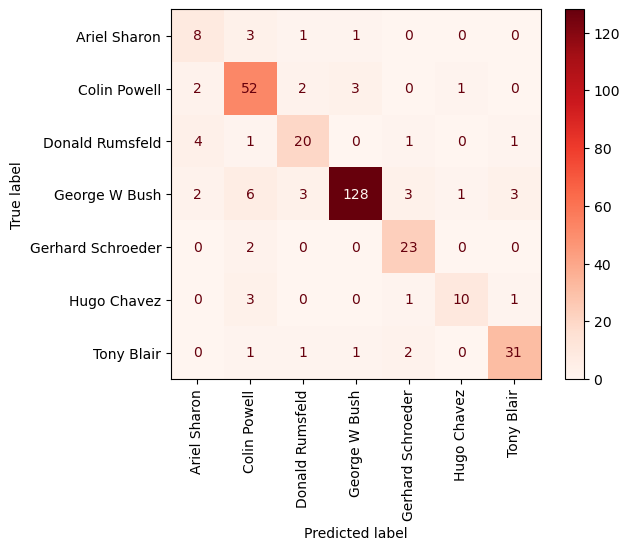

In [29]:
display=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
display.plot(cmap='Reds',colorbar=True,xticks_rotation="vertical")

In [30]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

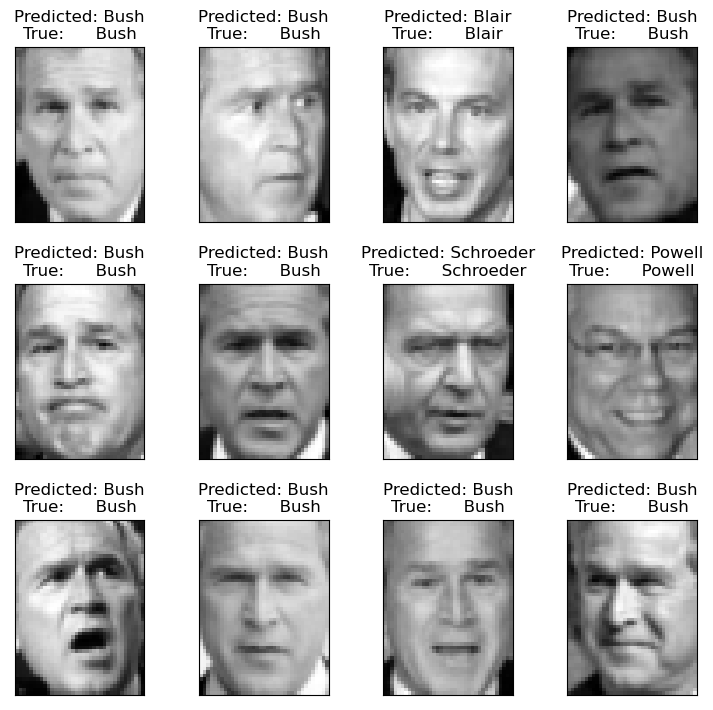

In [31]:
def title(Y_pred, Y_test, target_names, i):
    pred_name = target_names[Y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[Y_test[i]].rsplit(" ", 1)[-1]
    return "Predicted: %s\nTrue:      %s" % (pred_name, true_name)


prediction_titles = [title(Y_pred, Y_test, target_names, i) for i in range(Y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, height, width)

In [32]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7, 10, 15], 'metric': ['euclidean', 'manhattan', 'minkowski'] }
grid_search = GridSearchCV(knn, param_grid, cv=5)

t0 = time.time()
grid_search.fit(X_train_pca, Y_train)
print("Training done in %0.3fs" % (time.time() - t0))

print("Best parameters found:", grid_search.best_params_)
best_knn = grid_search.best_estimator_

print("Predicting on the test set")
t0 = time.time()
Y_pred = best_knn.predict(X_test_pca)
print("Prediction done in %0.3fs" % (time.time() - t0))

print("Classification Report:")
print(classification_report(Y_test, Y_pred, target_names=target_names))

print("Confusion Matrix is:")
print(confusion_matrix(Y_test, Y_pred, labels=range(len(target_names))))



Training done in 1.285s
Best parameters found: {'metric': 'manhattan', 'n_neighbors': 3}
Predicting on the test set
Prediction done in 0.053s
Classification Report:
                   precision    recall  f1-score   support

     Ariel Sharon       0.36      0.31      0.33        13
     Colin Powell       0.85      0.65      0.74        60
  Donald Rumsfeld       0.50      0.30      0.37        27
    George W Bush       0.65      0.96      0.78       146
Gerhard Schroeder       0.83      0.20      0.32        25
      Hugo Chavez       0.88      0.47      0.61        15
       Tony Blair       0.70      0.39      0.50        36

         accuracy                           0.67       322
        macro avg       0.68      0.47      0.52       322
     weighted avg       0.69      0.67      0.64       322

Confusion Matrix is:
[[  4   1   1   5   0   1   1]
 [  3  39   1  16   0   0   1]
 [  2   1   8  16   0   0   0]
 [  0   2   2 140   0   0   2]
 [  1   0   1  16   5   0   2]
 [  1  

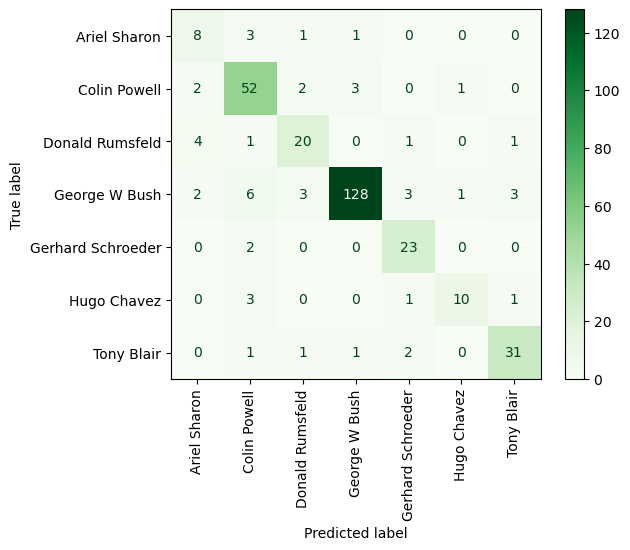

In [33]:
display=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
display.plot(cmap='Greens',colorbar=True,xticks_rotation="vertical")

In [38]:
log_reg = LogisticRegression()

param_grid = {'C': [0.01, 0.1, 1, 10, 100],'solver': ['liblinear', 'lbfgs'], 'max_iter': [100, 200, 300]}

grid_search = GridSearchCV(log_reg, param_grid, cv=5)

print("Fitting the classifier to the training set")
t0 = time.time()
grid_search.fit(X_train_pca, Y_train)
print("Training done in %0.3fs" % (time.time() - t0))

print("Best parameters found:", grid_search.best_params_)
best_lr = grid_search.best_estimator_

print("Predicting on the test set")
t0 = time.time()
Y_pred = grid_search.predict(X_test_pca)
print("Prediction done in %0.3fs" % (time.time() - t0))

print("Classification Report:")
print(classification_report(Y_test, Y_pred, target_names=target_names))

print("Confusion Matrix is:")
print(confusion_matrix(Y_test, Y_pred, labels=range(len(target_names))))
cm=confusion_matrix(Y_test, Y_pred, labels=range(len(target_names)))

Fitting the classifier to the training set
Training done in 15.642s
Best parameters found: {'C': 0.01, 'max_iter': 100, 'solver': 'liblinear'}
Predicting on the test set
Prediction done in 0.001s
Classification Report:
                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.54      0.67        13
     Colin Powell       0.73      0.87      0.79        60
  Donald Rumsfeld       0.72      0.85      0.78        27
    George W Bush       0.91      0.90      0.91       146
Gerhard Schroeder       0.90      0.76      0.83        25
      Hugo Chavez       0.83      0.67      0.74        15
       Tony Blair       0.85      0.78      0.81        36

         accuracy                           0.84       322
        macro avg       0.83      0.77      0.79       322
     weighted avg       0.85      0.84      0.84       322

Confusion Matrix is:
[[  7   2   3   1   0   0   0]
 [  1  52   1   4   0   1   1]
 [  0   2  23   1   0   0   1]
 [  0   7   4 1

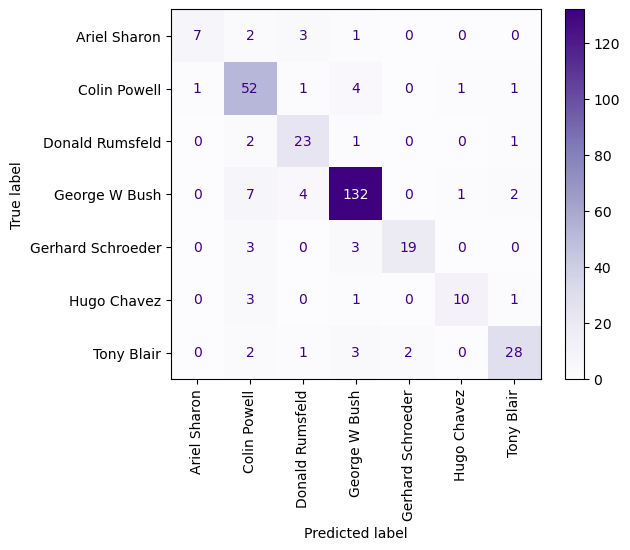

In [39]:
display=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
display.plot(cmap='Purples',colorbar=True,xticks_rotation="vertical")

In [40]:
#CALCULATING MEAN FACES

In [41]:
data = fetch_lfw_people()
faces = data.images 
print(faces.shape)

(13233, 62, 47)


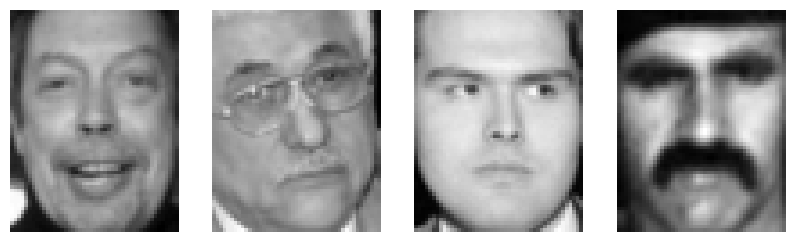

In [42]:
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
for i in range(4):
    ax[i].imshow(faces[i], cmap='gray')
    ax[i].axis('off')
plt.show()

In [43]:
faces_flat = faces.reshape(faces.shape[0], -1)

In [44]:
print(faces_flat.shape)

(13233, 2914)


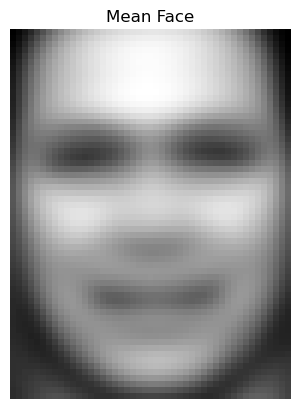

In [45]:
mean_face_vector = np.mean(faces_flat, axis=0)
mean_face_reshape = mean_face_vector.reshape(62, 47)

# Visualize the mean face
plt.imshow(mean_face_reshape, cmap='gray')
plt.title('Mean Face')
plt.axis('off')
plt.show()

In [46]:
print(mean_face_vector.shape)

(2914,)


In [47]:
print(mean_face_vector)

[ 73.64502   76.609215  82.047195 ... 106.37096  102.72338   99.468056]


In [48]:
print(mean_face_reshape.shape)

(62, 47)


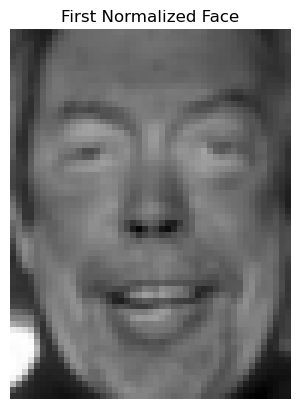

In [49]:
normalized_faces = faces - mean_face_reshape

plt.imshow(normalized_faces[0], cmap='gray')
plt.title('First Normalized Face')
plt.axis('off')
plt.show()


In [50]:
print(normalized_faces.shape)

(13233, 62, 47)
